In [191]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation

from scipy.ndimage import measurements
from scipy import signal
from scipy import ndimage as ndi

from skimage.filters import threshold_multiotsu
from skimage.morphology import reconstruction



import seaborn as sns

In [192]:
os.chdir('/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023')
list_of_tiffs = os.listdir('/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023')
print(list_of_tiffs[0])

np.isin(np.array(list_of_tiffs), np.array('thickstack'))

list_of_tiffs_annotated = [s for s in list_of_tiffs if 'thickstack' in s]
#list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if 'slice' not in s]
#list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if 'thinstack' not in s]
print(len(list_of_tiffs_annotated))

#list_of_tiffs_annotated = list_of_tiffs_annotated[29:34]
#print(list_of_tiffs_annotated)

13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-06(12).tif
18


In [239]:
class OneCell():
    def __init__(self, cell_num, dapi_sum_img, draq_sum_img, trans_img, cell_mask, **kwargs):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        #self.cell_mask = cell_mask 
        self.cell_mask = morphology.erosion(cell_mask, morphology.disk(7))
        
        self.trans_img = trans_img

        self.dapi_sum_img = dapi_sum_img
        self.draq_sum_img = draq_sum_img


        self.dapi_norm = self.dapi_sum_img#(self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm = self.draq_sum_img#(self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros = np.zeros_like(self.dapi_norm)

        #self.dapi_norm_plot = (self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        #self.draq_norm_plot = (self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        #zeros_plot = np.zeros_like(self.dapi_norm_plot)

        #self.rgb_overlay = np.stack([self.draq_norm_plot, zeros_plot, self.dapi_norm_plot], axis=-1)  # red - DAPI, green - Draq5

        # nDNA/kDNA masking
        #self.k_mask, self.n_mask, self.kn_label, self.kn_mask, self.mask_qual, self.n_ndi_labels, self.n_ndi_num, self.n_mask_reg = self.create_kineto_mask(dapi_norm_plot=self.dapi_norm_plot,
        #                                                                                                draq_norm_plot=self.draq_norm_plot,
        #                                                                                                **kwargs)


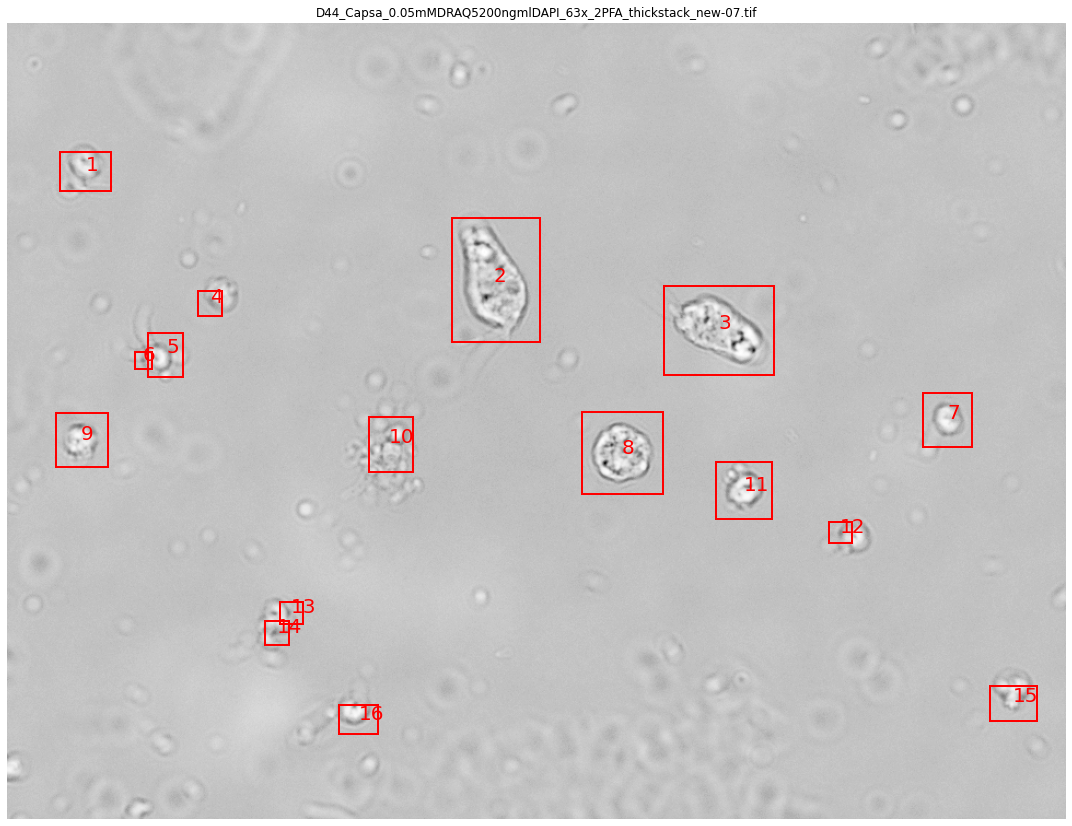

In [257]:
img_raw = io.imread("/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023/" + str("13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-06(12).tif"))
img_ch0 = img_raw[:,:,:,0]
img_ch1 = img_raw[:,:,:,1]
img_ch2 = img_raw[:,:,:,2]

######Background substraction for the whole image in each separate slice of each channel (D)
new_array1 = np.zeros_like(img_ch2, dtype='int64')[0,:,:]

for sl in list(range(len(img_ch2))) :
    new_array = (img_ch2[sl,:,:] - np.min(img_ch2[sl,:,:])) / (np.max(img_ch2[sl,:,:]) - np.min(img_ch2[sl,:,:]))        
    new_array1= np.append(new_array1,new_array, axis = 0)
    
new_array1 = new_array1.reshape(len(img_ch2)+1, *np.array(new_array).shape)
img_dapi = new_array1[1:len(img_ch2)+1,:,:]
    
    
new_array2 = np.zeros_like(img_ch1, dtype='int64')[0,:,:]

for sl in list(range(len(img_ch1))) :
    new_array_b = (img_ch1[sl,:,:] - np.min(img_ch1[sl,:,:])) / (np.max(img_ch1[sl,:,:]) - np.min(img_ch1[sl,:,:]))
    new_array2= np.append(new_array2,new_array_b, axis = 0)
    
new_array2 = new_array2.reshape(len(img_ch1)+1, *np.array(new_array_b).shape)
img_draq = new_array2[1:len(img_ch1)+1,:,:]
######Background substraction for the whole image in each separate slice of each channel (D)

    
img_trans = np.max(img_ch0, axis=0)
img_dapi_sum = np.sum(img_dapi, axis=0)# dtype='int64')
img_draq_sum = np.sum(img_draq, axis=0)# dtype='int64')

######Some dark magic to detect separate cells in trans channel (B)
img_trans_filt = filters.gaussian(img_trans, sigma=2)

img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
mask = ndi.binary_fill_holes(mask)
mask = segmentation.clear_border(mask)
####???Change morph.disk below to optimise trans cell detection? (D)
mask = morphology.erosion(mask, morphology.disk(5))
mask = morphology.dilation(mask, morphology.disk(7))

labels, labels_num = ndi.label(mask)

ctrl_fluo_img = img_dapi_sum + img_draq_sum
ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
connected = sums > 0
debris_mask = connected[labels]

fin_mask = np.copy(mask)
fin_mask[~debris_mask] = 0
    ###############clear cell boundaries
    #fin_mask = morphology.erosion(fin_mask, morphology.disk(5))
    ###############
cells_labels, cells_num = ndi.label(fin_mask)


fig, ax = plt.subplots(figsize=(15, 15))
#####!!!!!!!!!!Change the slice numbers below depending on stack type
ax.imshow(np.max(img_raw[4:5,:,:,0], axis=0), cmap='Greys')
#####!!!!!!!!!!Change the slice numbers above depending on stack type
ax.set_axis_off()
ax.set_title(tiff)

cells_list = []
for region in measure.regionprops(cells_labels):
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=20)
######Some dark magic to detect separate cells in trans channel (B)

######Adding single cells to the list and making OneCell object of each cell (B)
    cells_list.append(OneCell(cell_num=region.label,
                            dapi_sum_img=img_dapi_sum[minr:maxr, minc:maxc],
                            draq_sum_img=img_draq_sum[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_mask[minr:maxr, minc:maxc],
                            filter_n=False, show_debug_img=False))

plt.tight_layout()
plt.title(tiff)
plt.show()










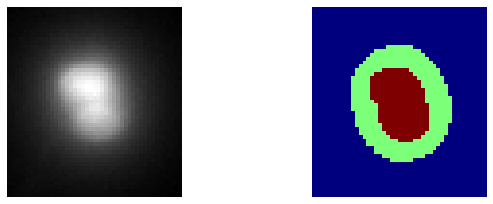

[0 1 2]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0
0.0
1/2/3:  2
Nucleus and kDNA separated


ValueError: After discretization into bins, the input image has only 1 different values. It cannot be thresholded in 3 classes. If there are more unique values before discretization, try increasing the number of bins (`nbins`).

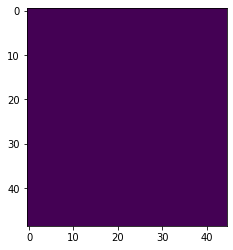

In [258]:
cell = cells_list[6]


##########Step I
#####I-1 -- OTSU background+cytoplasm detection in DRAQ channel
bg_otsu_threshold = threshold_multiotsu(cell.draq_sum_img,classes = 3)
bg_otsu = np.digitize(cell.draq_sum_img, bins=bg_otsu_threshold)
#morphology_extension - to avoid leaving out edges of i.e. nuclei; disk can vary?
#bg_otsu = morphology.dilation(bg_otsu, morphology.disk(2))

#plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
ax[0].imshow(cell.dapi_sum_img , cmap='gray')
ax[0].axis('off')
#ax[1].hist(cell.dapi_sum_img.ravel(), bins=255)
#ax[1].axis('off')
ax[1].imshow(bg_otsu, cmap='jet')
ax[1].axis('off')
plt.show()

######I-2 -- Delete background completely in DAPI and DRAQ5 channel, leaving only a circle corresponding to cell
print(np.unique(bg_otsu))
cell_nonbg_mask = bg_otsu < 2
#print(cell_nonbg_mask.astype(np.bool))

cell.dapi_nobg = cell.dapi_sum_img
cell.draq_nobg = cell.draq_sum_img
cell.dapi_nobg[cell_nonbg_mask] = 0
cell.draq_nobg[cell_nonbg_mask] = 0
#plot
plt.imshow(cell.draq_nobg)
print(cell.dapi_nobg)

######I-3 -- Obtain the part corresponding to background+cytoplasm in DAPI and DRAQ5 channel, 
#leaving out a circle corresponding to cell
cell_bgtodel_mask = bg_otsu == 2

cell.dapi_bgtodel = cell.dapi_sum_img
cell.draq_bgtodel = cell.draq_sum_img
cell.dapi_bgtodel[cell_bgtodel_mask] = 0 #ma.masked_where(~cell_bgtodel_mask.astype(np.bool),cell.dapi_sum_img)
cell.draq_bgtodel[cell_bgtodel_mask] = 0 #ma.masked_where(~cell_bgtodel_mask.astype(np.bool),cell.draq_sum_img)
#plot
plt.imshow(cell.draq_bgtodel)

######I-4 -- Substract average intensity of background+cytoplasm in DAPI and DRAQ5 channel
#from nucleus+kDNA region
cell.dapi_normalised = cell.dapi_nobg - np.average(cell.dapi_bgtodel)
cell.draq_normalised = cell.draq_nobg - np.average(cell.draq_bgtodel)
#plot
plt.imshow(cell.draq_normalised)
#control that masks worked
print(np.average(cell.dapi_bgtodel))
print(np.average(cell.dapi_nobg))

##########Step II - thresholding in 2 or 3 classes

check = input('1/2/3:  ')
if check == '1':
    print("Control species, only nucleus considered")
    nucl_int = np.sum(cell.draq_normalised)
    kDNA_int = 0
    print(nucl_int)
    
elif check == '2':
    print("Nucleus and kDNA separated")
    #erosion to compensate for the shift of regions of interest between DAPI and DRAQ5 channels 
    #(likely some physical thing because of wavelengths?)
    #!!!!Morphology.disk below - adjustable?
    cell.dapi_normalised_eroded = morphology.erosion(cell.dapi_normalised, morphology.disk(1))
    
    sepdapi_otsu_threshold = threshold_multiotsu(cell.dapi_normalised_eroded,classes = 3)
    dapiknucl_otsu = np.digitize(cell.dapi_normalised_eroded, bins=sepdapi_otsu_threshold)
    
    cell_nucl_mask = dapiknucl_otsu==1
    #cell_nucl_mask = morphology.opening(cell_nucl_mask, morphology.disk(10))
    cell.draq_nucl = ma.masked_where(~cell_nucl_mask.astype(np.bool),cell.draq_normalised)
    nucl_int = np.sum(cell.draq_nucl) 
    
    cell_kDNA_mask = dapiknucl_otsu==2
    cell.draq_kDNA = ma.masked_where(~cell_kDNA_mask.astype(np.bool),cell.draq_normalised)
    kDNA_int = np.sum(cell.draq_kDNA) 

    #plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
    ax[0].imshow(cell.draq_nucl, cmap='jet')
    ax[0].axis('off')
    ax[1].imshow(cell.draq_kDNA, cmap='jet')
    ax[1].axis('off')
    plt.show()

    
elif check == '3':
    print("Nucleus and kDNA overlayed")
    


In [8]:
#################Old
class OneCell():
    def __init__(self, cell_num, dapi_img, dapi_sum_img, draq_img, draq_sum_img, trans_img, cell_mask, **kwargs):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        #self.cell_mask = cell_mask 
        self.cell_mask = morphology.erosion(cell_mask, morphology.disk(7))
        
        
        self.dapi_img = dapi_img
        self.draq_img = draq_img
        self.trans_img = trans_img

        self.dapi_sum_img = dapi_sum_img
        self.draq_sum_img = draq_sum_img


        self.dapi_norm = self.dapi_sum_img#(self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm = self.draq_sum_img#(self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros = np.zeros_like(self.dapi_norm)

        self.dapi_norm_plot = (self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm_plot = (self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros_plot = np.zeros_like(self.dapi_norm_plot)

        self.rgb_overlay = np.stack([self.draq_norm_plot, zeros_plot, self.dapi_norm_plot], axis=-1)  # red - DAPI, green - Draq5

        # nDNA/kDNA masking
        self.k_mask, self.n_mask, self.kn_label, self.kn_mask, self.mask_qual, self.n_ndi_labels, self.n_ndi_num, self.n_mask_reg = self.create_kineto_mask(dapi_norm_plot=self.dapi_norm_plot,
                                                                                                        draq_norm_plot=self.draq_norm_plot,
                                                                                                        **kwargs)
         
    
    @staticmethod
    def create_kineto_mask(dapi_norm_plot, draq_norm_plot, filter_n=False, show_debug_img=False):
        
        #print(max(np.unique(dapi_norm))-min(np.unique(dapi_norm)))
        
        thresholds = threshold_multiotsu(dapi_norm_plot,classes = 4)
        regions = np.digitize(dapi_norm_plot, bins=thresholds)

        thresholds_draq = threshold_multiotsu(draq_norm_plot,classes = 3)
        regions_draq = np.digitize(draq_norm_plot, bins=thresholds_draq)

        MAX = max(np.unique(regions_draq))
        n_mask = regions_draq==MAX
        n_mask_reg = n_mask
        #####################making sure only 1 nucleus gets detected
        n_ndi_labels, n_ndi_num = ndi.label(n_mask)
        n_mask = (n_ndi_labels==np.bincount(n_ndi_labels.ravel())[1:].argmax()+1).astype(int)
        
        if len(np.bincount(n_ndi_labels.ravel())[1:]) > 0:
            n_mask_reg = (n_ndi_labels==np.bincount(n_ndi_labels.ravel())[1:].argmax()+1).astype(int)
            n_mask_reg = n_mask_reg.astype(np.bool)
        else:
            n_mask_reg = n_mask
            

        #erosion to compensate for halo?
        #n_mask = morphology.erosion(n_mask, morphology.disk(1.5))
        #####################
        
        MAXd = max(np.unique(regions))
        k_mask_prim = regions==MAXd
  
        
        
        
        ###############################################################
        #Here is where the fun begins#
        #filtering those bitch nuclei and kDNA that are either overlayed or kissing
        
        overlap_mask = np.ma.masked_where(n_mask_reg == 0,  k_mask_prim)
        overlap_mask2 = np.ma.masked_where(k_mask_prim == 0,  overlap_mask)

        dapi_to_draq = dapi_norm_plot-draq_norm_plot
        ####!!!!!!!!!!On the line above I actually need a ratio most optimally imo but it doesnt like division by 0
        ##To fix it later (If fail googling need help)
        m_ov = np.zeros_like(dapi_norm_plot) 
        
        #Old version
        m_ov[overlap_mask2] = dapi_to_draq[overlap_mask2]
        threshold = filters.threshold_otsu(m_ov)
        
        #!!!!! The old and wrong version
        #threshold = filters.threshold_otsu(overlap_mask2)
        
        overlay2_size = np.count_nonzero(m_ov[overlap_mask2])        
        n_size = np.count_nonzero(m_ov[overlap_mask2] < threshold)       
        k_size = np.count_nonzero(m_ov[overlap_mask2] > threshold)
        
        if n_size == 0:
            area_ratio = 100
        else:
            area_ratio = k_size/n_size # i.e. area of kDNA:area_nuclear !!!ONLY WITHIN PUTATIVE OVERLAP REGION!!!
        
        print(area_ratio)
        
        ###############################################################

        k_mask = k_mask_prim.astype(np.bool)
        k_maskEXT = morphology.dilation(k_mask, morphology.disk(1))
        
        n_mask[k_maskEXT.astype(np.bool)]= 0
        n_mask_reg = n_mask_reg.astype(np.bool)
        n_mask = n_mask.astype(np.bool)
        
        #n_mask1 = morphology.erosion(n_mask, morphology.disk(3.5))
        
        #n_mask = morphology.thin(n_mask, max_num_iter=4)
        #n_mask = morphology.dilation(n_mask, morphology.disk(1.5))
        
        #################
        #n_mask_to_remove = morphology.opening(n_mask, morphology.disk(8))
        #n_mask[n_mask_to_remove.astype(np.bool)]= 0
        #
        n_mask = morphology.erosion(n_mask, morphology.disk(1))
        
        n_mask = morphology.dilation(n_mask, morphology.disk(2))
        ###############3
        n_mask = n_mask.astype(np.bool)
        
        
        
        n_ndi_labels, n_ndi_num = ndi.label(n_mask)
        if len(np.bincount(n_ndi_labels.ravel())[1:]) > 1:
            n_mask = (n_ndi_labels==np.bincount(n_ndi_labels.ravel())[1:].argmax()+1).astype(int)
        
        if len(np.bincount(n_ndi_labels.ravel())[1:]) > 0:
            n_mask = (n_ndi_labels==np.bincount(n_ndi_labels.ravel())[1:].argmax()+1).astype(int)
            n_mask = n_mask.astype(np.bool)
        else:
            n_mask = n_mask
        
    
        k_mask = ndi.binary_fill_holes(k_mask)
        n_mask = ndi.binary_fill_holes(n_mask)
    
        n_mask[k_mask.astype(np.bool)]= 0
        
        kn_label = np.zeros_like(dapi_norm_plot)
        kn_label[k_mask] = 1
        kn_label[n_mask] = 2

        kn_mask = kn_label != 0

        mask_qual = ''
        
        
        
        
        
        if np.sum(n_mask) > np.size(k_mask) * 1.5:
            mask_qual = '(bad mask)'
        
        if show_debug_img:
            plt.figure(figsize=(15,15))


        return k_mask, n_mask, kn_label, kn_mask, n_ndi_labels, n_ndi_num, n_mask_reg, mask_qual
    
    def create_kineto_mask_old(self):
        """ previous detection method
        
        """ 
        

        diff = self.dapi_norm - self.draq_norm
        self.k_mask_raw = diff > filters.threshold_otsu(diff)
        diff_masked = ma.masked_where(~self.k_mask_raw, diff)
        self.k_mask = diff > filters.threshold_otsu(diff_masked.compressed())
        self.n_mask = self.draq_norm > filters.threshold_otsu(self.draq_norm)      
        if np.sum(self.k_mask) > np.size(diff) * 0.5:
            print("Bad mask")
        self.kn_label = np.zeros_like(self.dapi_img)
        self.kn_label[self.k_mask] = 1
        self.kn_label[self.n_mask] = 2
        self.kn_mask = self.kn_label != 0
        plt.figure(figsize=(10, 10))
        plt.imshow(self.trans_img, cmap='Greys')
        plt.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        plt.title('Red-nucleus')
        plt.axis('off')
        plt.show()
        
        
    def ctrl_masks_img(self):
        plt.figure(figsize=(12,3))

        ax0 = plt.subplot(131)
        ax0.imshow(self.trans_img, cmap='Greys')
        ax0.imshow(ma.masked_where(~self.cell_mask, self.cell_mask), cmap='jet', alpha=.3)
        ax0.set_title('Trans ch. with cell mask overlay')
        ax0.axis('off')

        ax1 = plt.subplot(132)
        ax1.imshow(self.rgb_overlay)
        ax1.set_title('DAPI-blue, Draq5-red')
        ax1.axis('off')

        ax2 = plt.subplot(133)
        ax2.imshow(self.trans_img, cmap='Greys')
        # plt.imshow(self.k_regions, cmap='bwr', alpha=.3)
        ax2.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        ax2.set_title('Red-nDNA, blue-kDNA')
        ax2.axis('off')
        
        #ax3 = plt.subplot(133)
        #ax3.imshow(self.n_mask, cmap='Greys')
        # plt.imshow(self.k_regions, cmap='bwr', alpha=.3)
        #ax3.set_title('Red-nDNA, blue-kDNA')
        #ax3.axis('off')

        
        plt.suptitle(f'Cell {self.cell_num}')
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12,3))
        
        ax0 = plt.subplot(131)
        ax0.imshow(self.k_mask, cmap='jet', alpha=.3)
        ax0.set_title('kDNA_area_for_int_calc')
        ax0.axis('off')

        ax1 = plt.subplot(132)
        ax1.imshow(self.n_mask, cmap='jet', alpha=.3)
        ax1.set_title('nuclearDNA_area_for_int_calc')
        ax1.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    def calc_cell_parameters(self):
        cell_df = pd.DataFrame({'num':self.cell_num,
                                'species':self.cell_species,
                                'cell_area':np.sum(self.cell_mask),
                                'kDNA_int':np.sum(self.draq_norm, where=self.k_mask),
                                'kDNA_area':np.sum(self.k_mask),
                                'nDNA_int':np.sum(self.draq_norm, where=self.n_mask),
                                'nDNA_area':np.sum(self.n_mask)},
                                index=[0])

        return cell_df

1


/tmp/ipykernel_12069/2733412822.py:53: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_mask_reg = n_mask_reg.astype(np.bool)
/tmp/ipykernel_12069/2733412822.py:100: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k_mask = k_mask_prim.astype(np.bool)
/tmp/ipykernel_12069/2733412822.py:103: DeprecationWarning: `np.bool` is a deprecated alias for the bu

1.5116279069767442
0.26480836236933797
0.6568627450980392
7.0
1.2391304347826086
3.125
0.8902439024390244
0.7569060773480663
1.4642857142857142
0.5697674418604651
3.935483870967742
1.8333333333333333
1.6470588235294117
0.53125
1.3333333333333333
0.25757575757575757


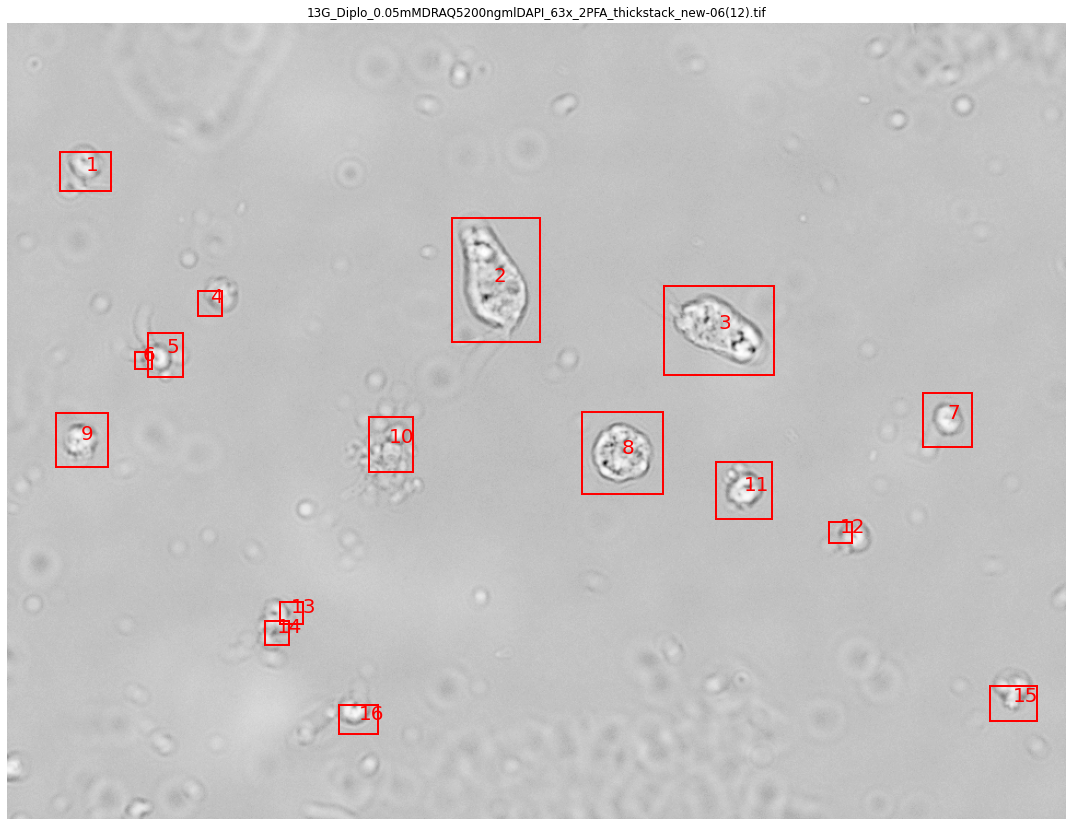

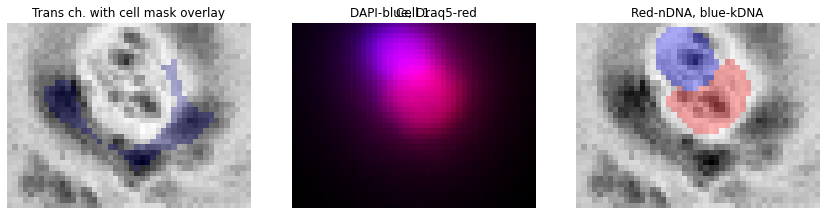

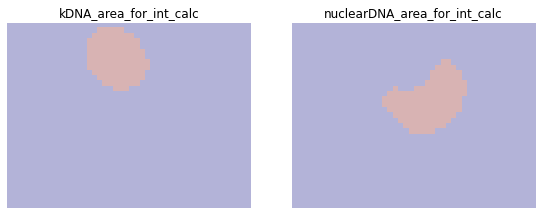

C/D/N/CD/CC/U:  


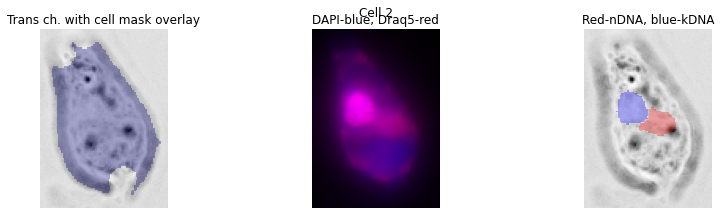

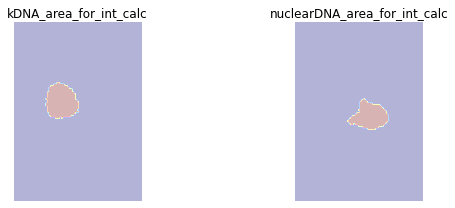

C/D/N/CD/CC/U:  


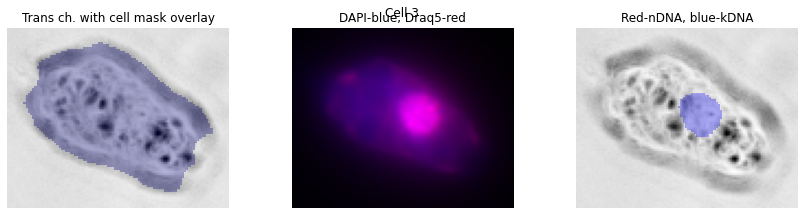

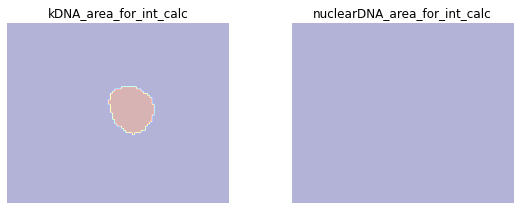

C/D/N/CD/CC/U:  


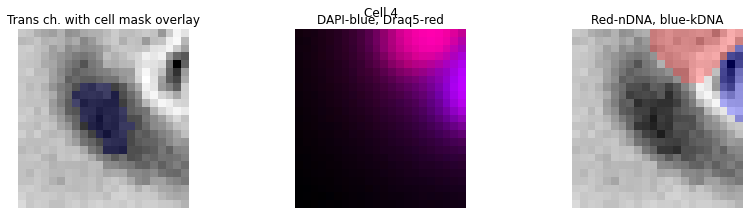

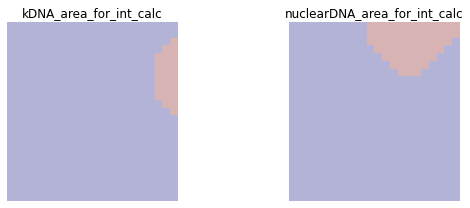

C/D/N/CD/CC/U:  


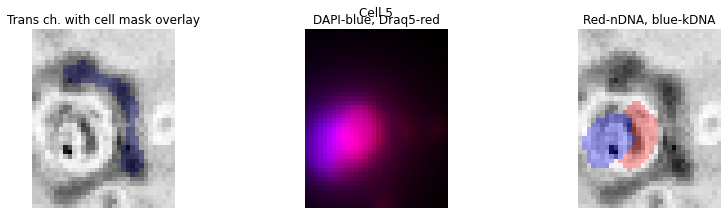

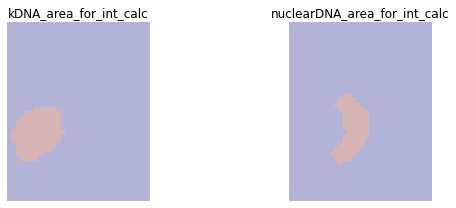

C/D/N/CD/CC/U:  


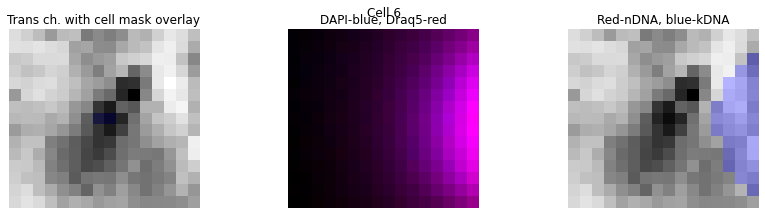

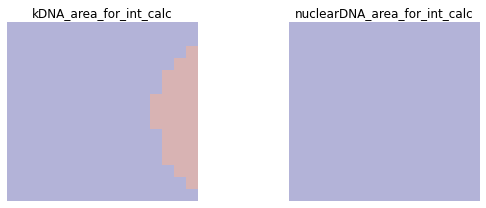

C/D/N/CD/CC/U:  


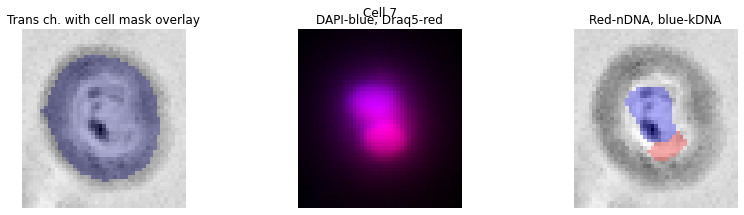

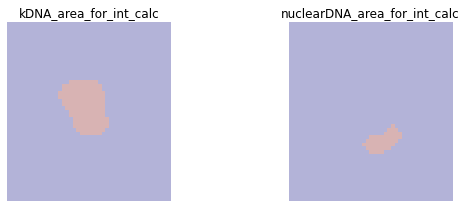

C/D/N/CD/CC/U:  


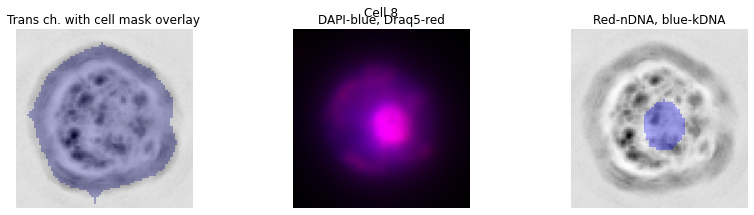

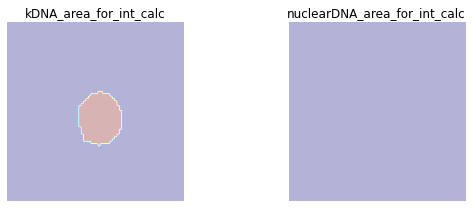

C/D/N/CD/CC/U:  


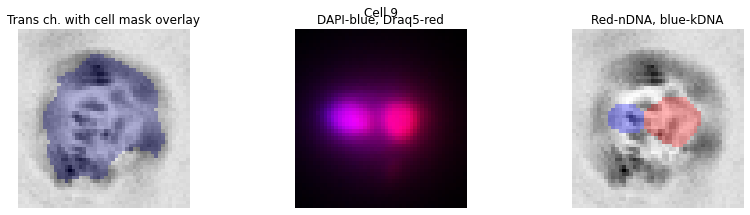

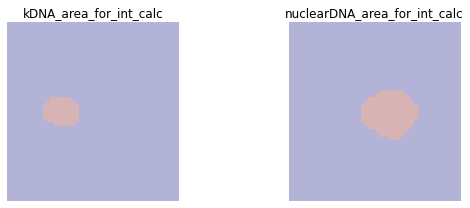

C/D/N/CD/CC/U:  


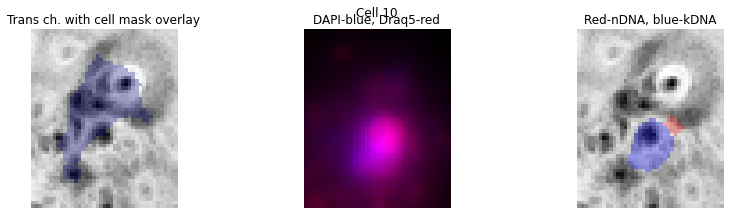

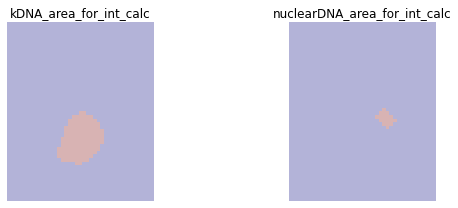

C/D/N/CD/CC/U:  


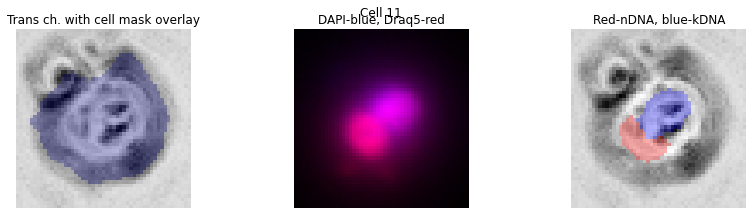

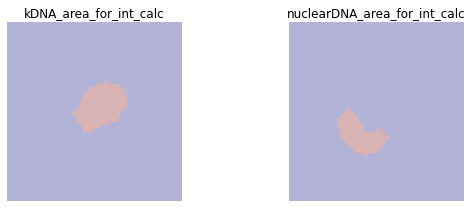

C/D/N/CD/CC/U:  


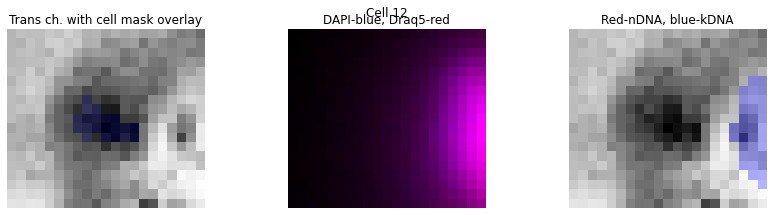

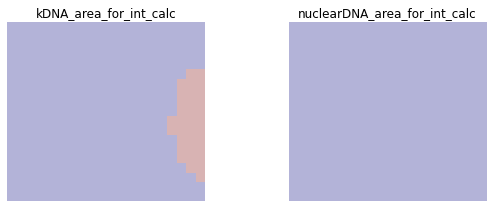

C/D/N/CD/CC/U:  


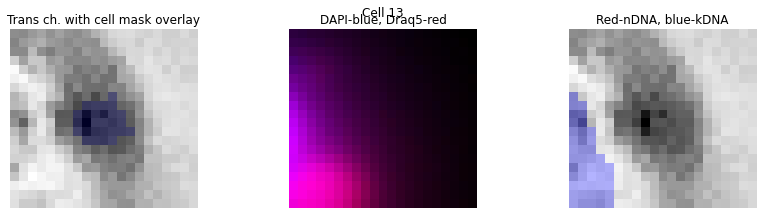

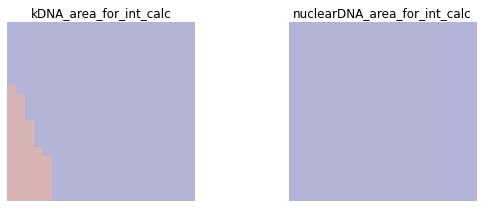

C/D/N/CD/CC/U:  


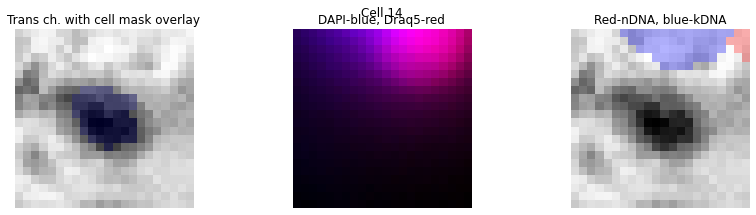

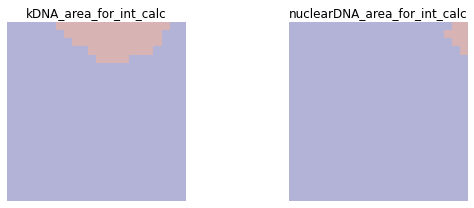

C/D/N/CD/CC/U:  


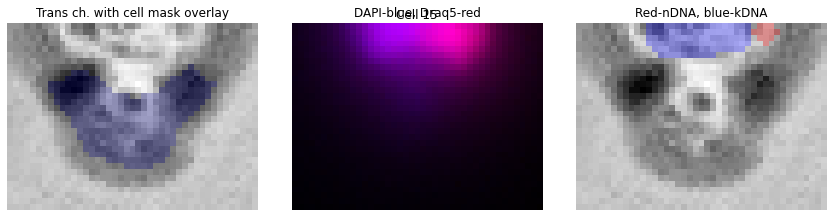

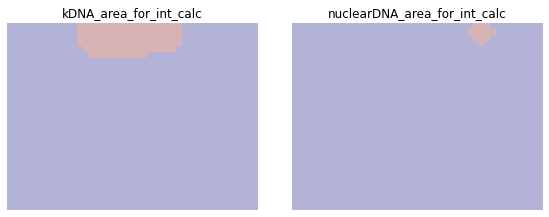

C/D/N/CD/CC/U:  


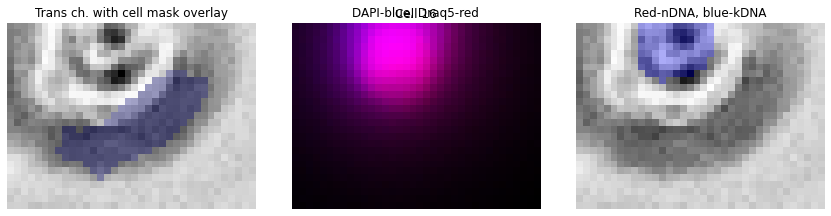

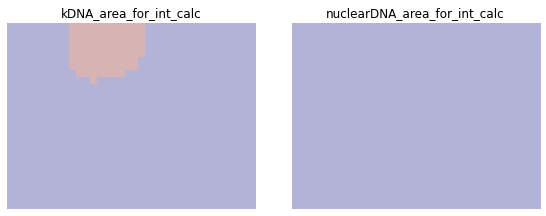

C/D/N/CD/CC/U:  
2
0.6728971962616822
1.2619047619047619
1.0823529411764705
0.7281553398058253
100
0.6666666666666666
1.6
4.45
1.1896551724137931
4.555555555555555
0.6790123456790124
0.9024390243902439
0.8712871287128713


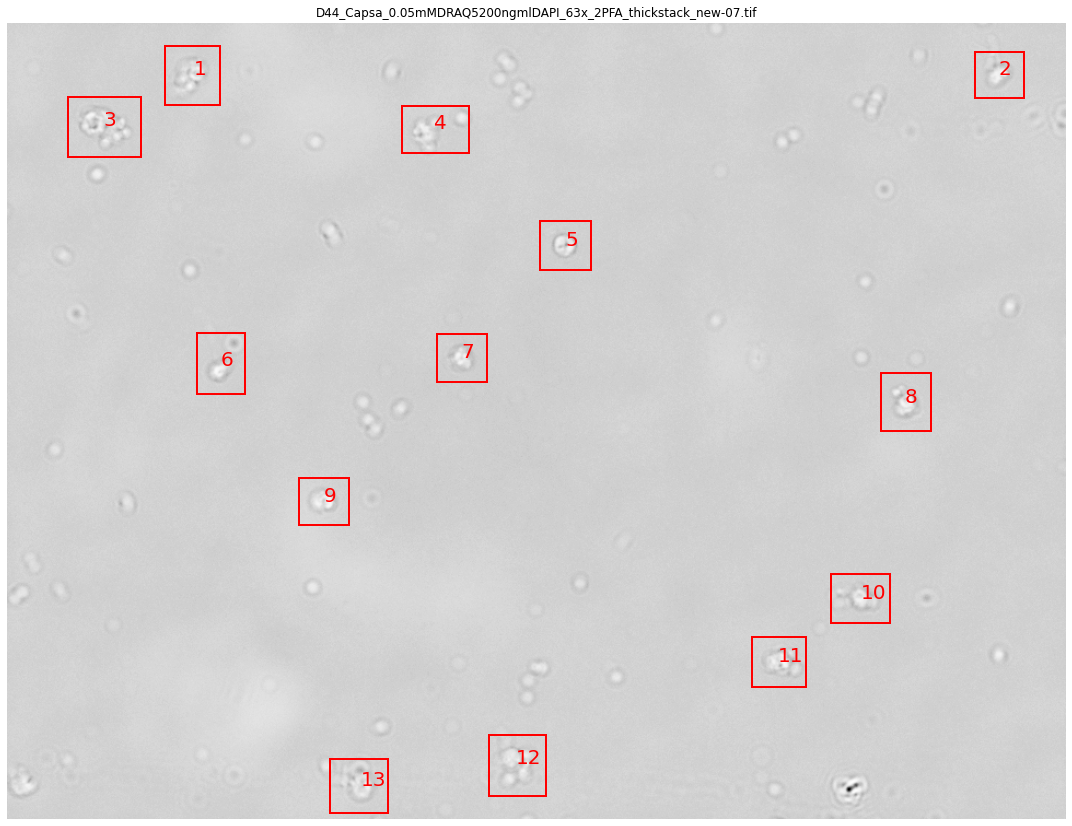

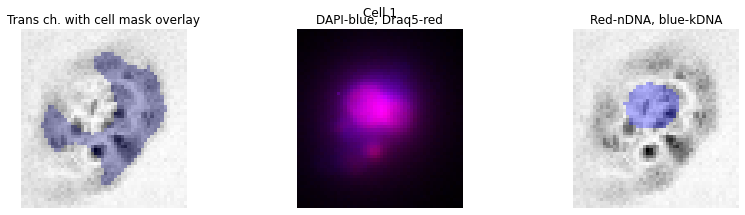

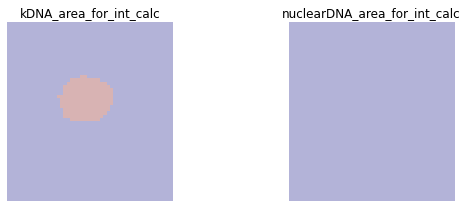

C/D/N/CD/CC/U:  


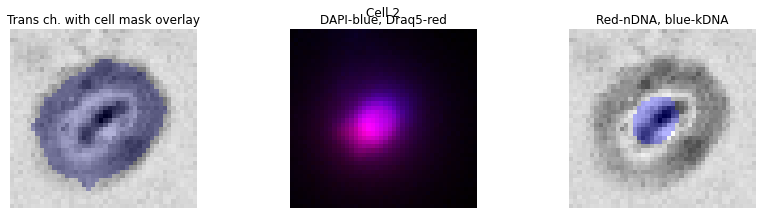

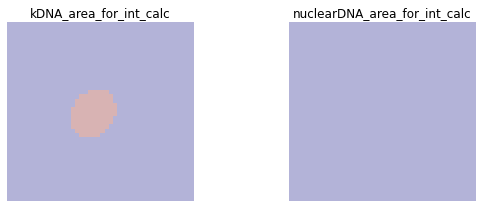

C/D/N/CD/CC/U:  


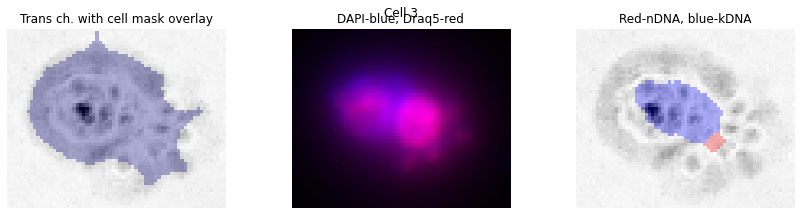

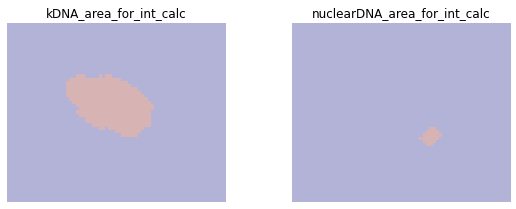

C/D/N/CD/CC/U:  


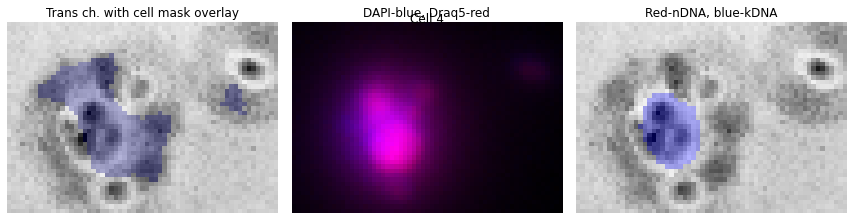

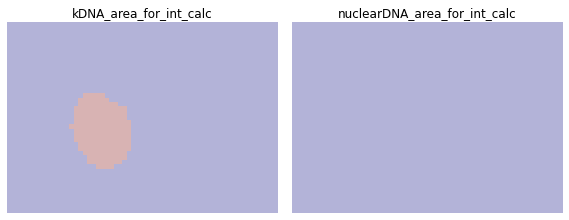

C/D/N/CD/CC/U:  


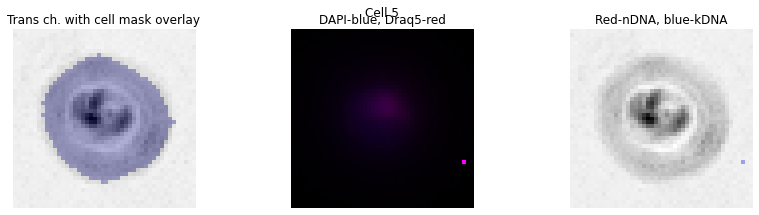

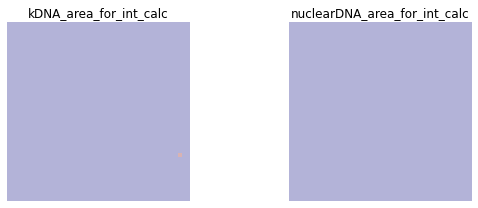

C/D/N/CD/CC/U:  


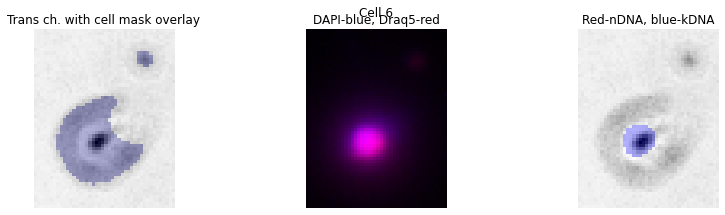

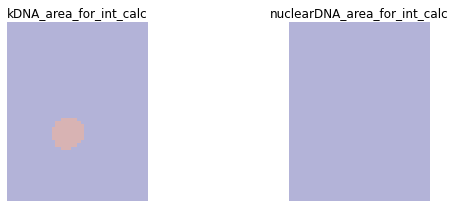

C/D/N/CD/CC/U:  


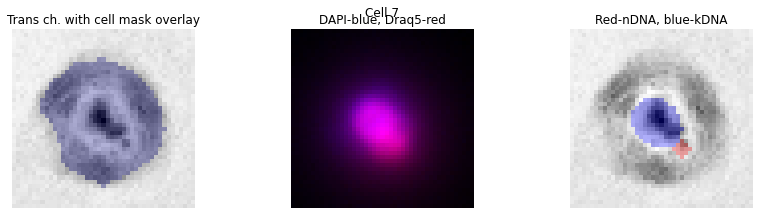

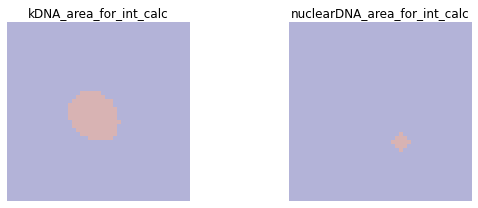

C/D/N/CD/CC/U:  


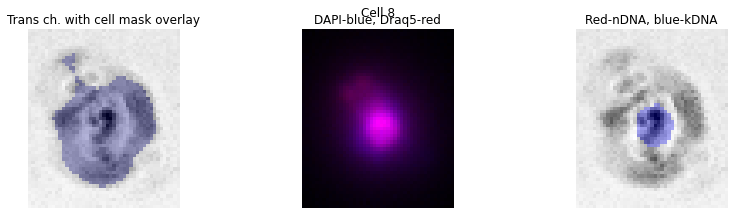

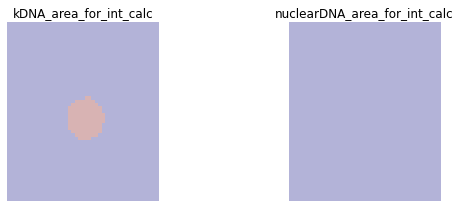

C/D/N/CD/CC/U:  


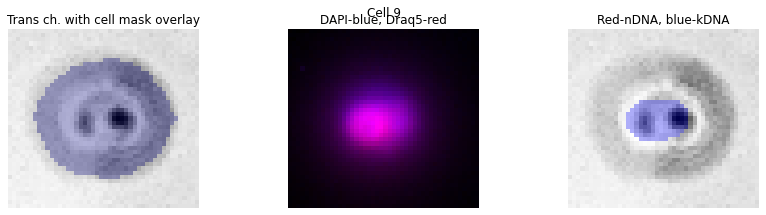

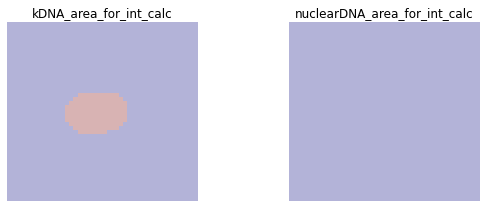

C/D/N/CD/CC/U:  


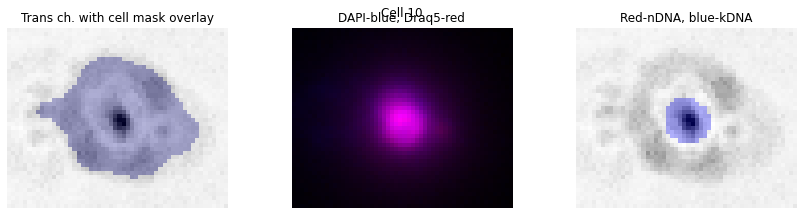

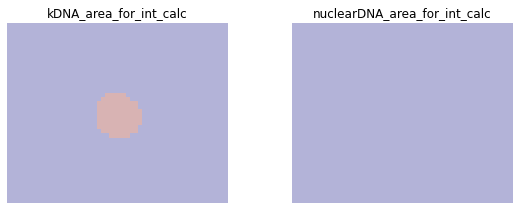

C/D/N/CD/CC/U:  


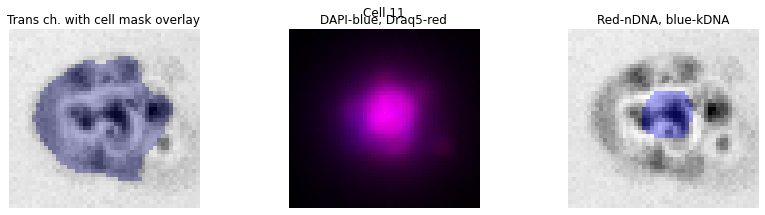

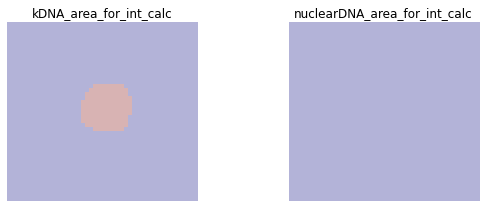

C/D/N/CD/CC/U:  


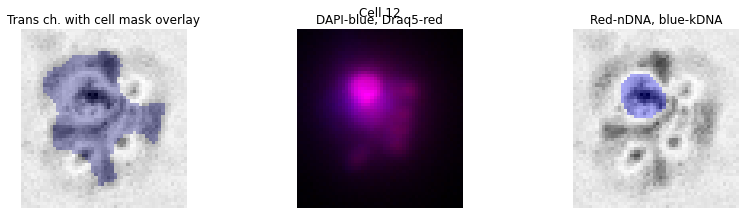

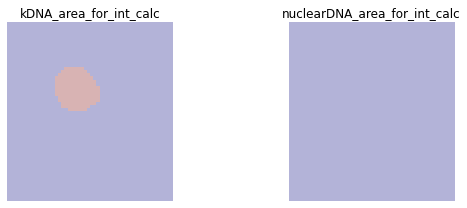

C/D/N/CD/CC/U:  


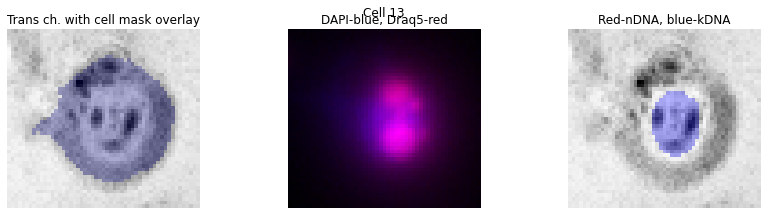

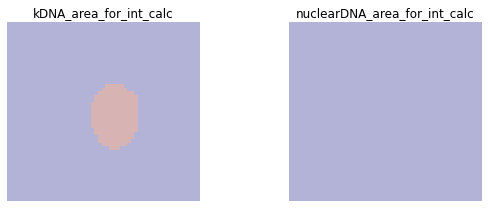

KeyboardInterrupt: Interrupted by user

In [10]:
#######Old

fin_out_df = pd.DataFrame(columns=['img_name',
                                   'num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])
i = 1
#['old_13G_Cruzella_0.05mMDRAQ5200ngmlDAPI_63x-06__200_DAPI_13G_1808_old.tif']
#['13G_Cruzella_0.05mMDRAQ5200ngmlDAPI_63x-12_200_DAPI_13G_1808_new.tif']
for tiff in list_of_tiffs_annotated :
    print(i)
    img_raw = io.imread("/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023/" + str(tiff))
    #img_raw = io.imread("/media/dzavadska/Elements/021123_13G_first_adequate_tiffs/13G_Srosetta_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thinstack_new-14.tif")
    img_ch0 = img_raw[:,:,:,0]
    img_ch1 = img_raw[:,:,:,1]
    img_ch2 = img_raw[:,:,:,2]

    new_array1 = np.zeros_like(img_ch2, dtype='int64')[0,:,:]

    for sl in list(range(len(img_ch2))) :
        new_array = (img_ch2[sl,:,:] - np.min(img_ch2[sl,:,:])) / (np.max(img_ch2[sl,:,:]) - np.min(img_ch2[sl,:,:]))        
        new_array1= np.append(new_array1,new_array, axis = 0)
    
    new_array1 = new_array1.reshape(len(img_ch2)+1, *np.array(new_array).shape)
    img_dapi = new_array1[1:len(img_ch2)+1,:,:]
    
    
    new_array2 = np.zeros_like(img_ch1, dtype='int64')[0,:,:]

    for sl in list(range(len(img_ch1))) :
        new_array_b = (img_ch1[sl,:,:] - np.min(img_ch1[sl,:,:])) / (np.max(img_ch1[sl,:,:]) - np.min(img_ch1[sl,:,:]))
        new_array2= np.append(new_array2,new_array_b, axis = 0)
    
    new_array2 = new_array2.reshape(len(img_ch1)+1, *np.array(new_array_b).shape)
    img_draq = new_array2[1:len(img_ch1)+1,:,:]
    
    #img_draq = img_draq.astype(np.int64)
    #img_dapi = img_dapi.astype(np.int64)
    
    img_trans = np.max(img_ch0, axis=0)
    #img_dapi = np.max(img_ch2, axis=0)
    #img_draq = np.max(img_ch1, axis=0)

    
    
    img_dapi_sum = np.sum(img_dapi, axis=0)# dtype='int64')
    img_draq_sum = np.sum(img_draq, axis=0)# dtype='int64')
    
    img_dapi = img_dapi_sum
    img_draq = img_draq_sum    
    ##########
    img_trans_filt = filters.gaussian(img_trans, sigma=2)

    img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
    img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

    mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
    mask = ndi.binary_fill_holes(mask)
    mask = segmentation.clear_border(mask)

    mask = morphology.erosion(mask, morphology.disk(5))
    mask = morphology.dilation(mask, morphology.disk(7))

    labels, labels_num = ndi.label(mask)
    ##########
    ctrl_fluo_img = img_dapi + img_draq
    ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

    sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
    connected = sums > 0
    debris_mask = connected[labels]

    fin_mask = np.copy(mask)
    fin_mask[~debris_mask] = 0
    ###############clear cell boundaries
    #fin_mask = morphology.erosion(fin_mask, morphology.disk(5))
    ###############
    cells_labels, cells_num = ndi.label(fin_mask)


    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(np.max(img_raw[4:5,:,:,0], axis=0), cmap='Greys')
    ax.set_axis_off()
    ax.set_title(tiff)

    cells_list = []
    for region in measure.regionprops(cells_labels):
        # if region.label == 3:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=20)

        cells_list.append(OneCell(cell_num=region.label,
                                dapi_img=img_dapi[minr:maxr, minc:maxc],
                                dapi_sum_img=img_dapi_sum[minr:maxr, minc:maxc],
                                draq_img=img_draq[minr:maxr, minc:maxc],
                                draq_sum_img=img_draq_sum[minr:maxr, minc:maxc],
                                trans_img=img_trans[minr:maxr, minc:maxc],
                                cell_mask=fin_mask[minr:maxr, minc:maxc],
                                filter_n=False,
                                show_debug_img=False))

    plt.tight_layout()
    plt.title(tiff)
    plt.show()
    
    good_cells_list = []
    for cell in cells_list:
        cell.ctrl_masks_img()
        check = input('C/D/N/CD/CC/U:  ')
        if check == 'N':
            print("fuck it")
            cell.cell_species = "Some_shit"
        elif check == 'C':
            good_cells_list.append(cell)
            cell.cell_species = "Diplo"
        elif check == 'D':
            good_cells_list.append(cell)
            cell.cell_species = "10D"
        elif check == 'CC':
            good_cells_list.append(cell)
            cell.cell_species = "Crappy_Diplo"
        elif check == 'CD':
            good_cells_list.append(cell)
            cell.cell_species = "Crappy_10D"
        elif check == 'U':
            good_cells_list.append(cell)
            cell.cell_species = "Undefined_euk_cell"  
    
    species_dict = {1:'A',      # only cells presented in this dict by numbers will be added to good cells list
                3:'A',
                4:'B',
                5:'C'}
#some strange previous version
    #good_cell(n_ndi_labels.ravel())[1:].sizes_list = []
    
    #for cell in cells_list:
    #    if cell.cell_num in species_dict.keys():
    #        cell.cell_species = species_dict[cell.cell_num]
    #        good_cells_list.append(cell)
    

    
    #for cell in cells_list:
    #    area = cell.calc_cell_parameters()['cell_area']
    #    ####(cell.mask_qual != '(bad mask)') & 
    #    if ((area > 100).bool()) & ((area < 6000).bool()) :
    #                cell.cell_species = "Not_yet_working"
    #                good_cells_list.append(cell)


    output_df = pd.DataFrame(columns=['num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])

    for cell in good_cells_list:
        cell_df = cell.calc_cell_parameters()

        output_df = pd.concat([output_df, cell_df],
                               ignore_index=True)
    
    
  
    # Using 'Address' as the column name
    # and equating it to the list
    output_df['img_name'] = tiff
    
    
    fin_out_df = pd.concat([fin_out_df, output_df])
    fin_out_df.to_csv('/home/dzavadska/Data/kDNA/fluo_methods/scripts/10D_Diplo_firstadequate_NORMandSUM_manual_thin033_refG_dilation2_erosion1.csv')
    i +=1